# Overview

Issues with LLMs

* LLMs may not always have access to specific or up-to-date context.
* When lacking proper context, LLMs are prone to hallucinations.



How to Fix This

Option 1: Fine-Tune the Model
* Train the LLM on your latest domain-specific data to improve relevance.
* However, there are challenges:
    * Repeated fine-tuning can cause model drift.
    * Fine-tuning is complex, time-consuming, and costly.

Option 2: Use RAG (Retrieval-Augmented Generation)
* Instead of modifying the model, RAG injects relevant external knowledge at query time.
* This gives the model access to fresh, specific, and controllable context — without retraining.

#Notebook Config

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install huggingface_hub langchain_community llama-cpp-python faiss-cpu --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 MB 18.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.2 MB/s eta 0:00:00


In [5]:
from langchain.llms import LlamaCpp
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA

from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download
import pandas as pd
import matplotlib.pyplot as plt

input_path = r"/content/drive/MyDrive/Colab Notebooks/NLP/rag/data"

# LLM

In [6]:
model_id = "TheBloke/Mistral-7B-Instruct-v0.1-GGUF"
filename = "mistral-7b-instruct-v0.1.Q4_K_M.gguf"

download_path = hf_hub_download(
    repo_id=model_id,
    filename=filename,
    cache_dir="./models"
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


mistral-7b-instruct-v0.1.Q4_K_M.gguf:   0%|          | 0.00/4.37G [00:00<?, ?B/s]

In [7]:
llm = LlamaCpp(
    model_path=download_path,
    temperature=0.1, # controls randomness, lesser value provides more deterministic output
    max_tokens=128,  # Max tokens to generate (output)
    n_ctx=1024,      # Total context window (input + output)
    verbose=False
)

llama_context: n_batch is less than GGML_KQ_MASK_PAD - increasing to 64
llama_context: n_ctx_per_seq (1024) < n_ctx_train (32768) -- the full capacity of the model will not be utilized
llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


# Why provide additional context to an LLM?

In [8]:
question = "Which section of the IPC deals with the offense of wearing the garb or carrying a token used by a soldier, sailor, or airman of the Indian armed forces, while not being one?"

context = "According to section 140 of Indian penal code, Whoever, not being a soldier, sailor or airman in the Military, Naval or Air service of the Government of India, wears any garb or carries any token resembling any garb or token used by such a soldier, sailor or airman with the intention that it may be believed that he is such a soldier, sailor or airman, shall be punished with imprisonment of either description for a term which may extend to three months, or with fine which may extend to five hundred rupees, or with both."

print("LLM output without context --->")
print(llm.invoke(question))

print("\n\n")

print("LLM output when provided with context --->")
print(llm.invoke(f"Use this context to answer the question: {context}. Question: {question}"))

LLM output without context --->

Answer: Section 120B of the Indian Penal Code



LLM output when provided with context --->

Answer: Section 140 of the Indian Penal Code.


# Data

In [9]:
ipc_df = pd.read_csv(f"{input_path}/ipc_sections.csv")

print(ipc_df.shape)
ipc_df.head()

(444, 4)


,Description,Offense,Punishment,Section
0,Description of IPC Section 140\nAccording to s...,Wearing the dress or carrying any token used b...,3 Months or Fine or Both,IPC_140
1,Description of IPC Section 127\nAccording to s...,Receiving property taken by war or depredation...,7 Years + Fine + forfeiture of property,IPC_127
2,Description of IPC Section 128\nAccording to s...,Public servant voluntarily allowing prisoner o...,Imprisonment for Life or 10 Years + Fine,IPC_128
3,Description of IPC Section 129\nAccording to s...,Public servant negligently suffering prisoner ...,Simple Imprisonment 3 Years + Fine,IPC_129
4,Description of IPC Section 130\nAccording to s...,"Aiding escape of, rescuing or harbouring, such...",Imprisonment for Life or 10 Years + Fine,IPC_130


In [10]:
print(ipc_df['Description'].tolist()[0])

Description of IPC Section 140
According to section 140 of Indian penal code, Whoever, not being a soldier, sailor or airman in the Military, Naval or Air service of the Government of India, wears any garb or carries any token resembling any garb or token used by such a soldier, sailor or airman with the intention that it may be believed that he is such a soldier, sailor or airman, shall be punished with imprisonment of either description for a term which may extend to three months, or with fine which may extend to five hundred rupees, or with both.


IPC 140 in Simple Words
If someone who is not a military member wears a uniform or carries something resembling a military uniform to deceive others into believing they are a soldier, sailor, or airman, they can be punished with up to three months in jail, a fine of up to five hundred rupees, or both.


In [11]:
ipc_df['content'] = ipc_df['Description'].str.split("\n\n").str[0].str.split("\n").str[1]
ipc_df['text_len'] = ipc_df['content'].str.split(" ").apply(len)

print(ipc_df['content'].tolist()[0])
print(ipc_df['text_len'].tolist()[0])

According to section 140 of Indian penal code, Whoever, not being a soldier, sailor or airman in the Military, Naval or Air service of the Government of India, wears any garb or carries any token resembling any garb or token used by such a soldier, sailor or airman with the intention that it may be believed that he is such a soldier, sailor or airman, shall be punished with imprisonment of either description for a term which may extend to three months, or with fine which may extend to five hundred rupees, or with both.
95


Token limit: 512


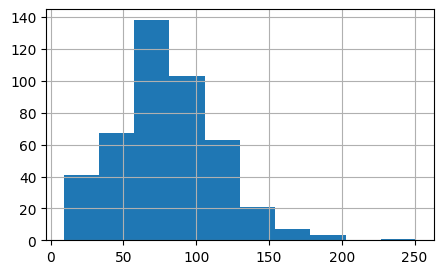

In [19]:
# The configured LLM supports a context window of up to 1048 tokens (input + output)
# If any paragraphs in the dataset exceeds a limit of say 700 tokens then better to chunk the text

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
print("Token limit:", tokenizer.model_max_length)

lengths = [len(tokenizer.tokenize(s)) for s in ipc_df['content'].tolist()]

plt.figure(figsize = (5, 3))
pd.DataFrame(data = lengths, columns = ['token_len'])['token_len'].hist()
plt.show()

In [13]:
documents = [
    Document(page_content=row["content"], metadata={"source": f"row_{i}"})
    for i, row in ipc_df.iterrows()
]

documents[0]

Document(metadata={'source': 'row_0'}, page_content='According to section 140 of Indian penal code, Whoever, not being a soldier, sailor or airman in the Military, Naval or Air service of the Government of India, wears any garb or carries any token resembling any garb or token used by such a soldier, sailor or airman with the intention that it may be believed that he is such a soldier, sailor or airman, shall be punished with imprisonment of either description for a term which may extend to three months, or with fine which may extend to five hundred rupees, or with both.')

In [14]:
# text_splitter = RecursiveCharacterTextSplitter(chunk_size = 250, chunk_overlap = 25)
# chunked_docs = text_splitter.split_documents(documents)

# Embeddings & Vector DB

In [15]:
# create embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# create a vector db for similarity based retrieval
vector_db = FAISS.from_documents(documents, embeddings)

/tmp/ipython-input-15-1394701029.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
vector_db.similarity_search(question, k=1)

[Document(id='20494408-9ed2-4443-88d8-681cf25d058c', metadata={'source': 'row_0'}, page_content='According to section 140 of Indian penal code, Whoever, not being a soldier, sailor or airman in the Military, Naval or Air service of the Government of India, wears any garb or carries any token resembling any garb or token used by such a soldier, sailor or airman with the intention that it may be believed that he is such a soldier, sailor or airman, shall be punished with imprisonment of either description for a term which may extend to three months, or with fine which may extend to five hundred rupees, or with both.')]

# RAG

In [17]:
rag_qa = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=vector_db.as_retriever(),
    return_source_documents=True
)

In [18]:
result = rag_qa.invoke(question)

print("Question:", question)
print("\nAnswer:", result["result"])
print("\nSource Document:", result["source_documents"][0].page_content)

Question: Which section of the IPC deals with the offense of wearing the garb or carrying a token used by a soldier, sailor, or airman of the Indian armed forces, while not being one?

Answer:  Section 140 of the Indian Penal Code deals with the offense of wearing the garb or carrying a token used by a soldier, sailor, or airman of the Indian armed forces, while not being one.

Source Document: According to section 140 of Indian penal code, Whoever, not being a soldier, sailor or airman in the Military, Naval or Air service of the Government of India, wears any garb or carries any token resembling any garb or token used by such a soldier, sailor or airman with the intention that it may be believed that he is such a soldier, sailor or airman, shall be punished with imprisonment of either description for a term which may extend to three months, or with fine which may extend to five hundred rupees, or with both.
